In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Install the dependencies

In [2]:
!pip install tensorflow

# Extract the crops disease dataset zip file

In [3]:
import zipfile
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/Crop_Disease.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()
print("Extract the dataset zip file successfully.")

Extract the dataset zip file successfully.


# Import the necessaries libraries

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg
%matplotlib inline
import cv2
import tensorflow as tf
from tensorflow.keras.utils import load_img, img_to_array
from numpy import expand_dims
from tensorflow.keras import layers, models
from keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import Dense,Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.layers import GlobalAvgPool2D as GAP, Dense, Dropout


# Loading the dataset

In [5]:
BASE_DIRECTORY = r'/content/Crop_Disease'
train_img_path = r'/content/Crop_Disease/train'
test_img_path = r'/content/Crop_Disease/test'
val_img_path = r'/content/Crop_Disease/val'

# Prepare the dataset

In [6]:
# Get a list of all class labels in the dataset
class_label = os.listdir(train_img_path)
print("Number of class labels found:", len(class_label))

Number of class labels found: 14


In [7]:
class_img_path = []

for class_lbl in class_label:
    # Get a list of all images in the current class
    class_img_name = os.listdir(os.path.join(train_img_path, class_lbl))

    # Add  class label and image path to list
    for img_name in class_img_name:
        img_path = os.path.join(train_img_path, class_lbl, img_name)
        class_img_path.append((class_lbl, img_path))

# Create a DataFrame from the list
df = pd.DataFrame(class_img_path, columns=['Class Label', 'Image Path'])
df

Class Label  \
0               Rice___Hispa   
1               Rice___Hispa   
2               Rice___Hispa   
3               Rice___Hispa   
4               Rice___Hispa   
...                      ...   
20632  Corn___Gray_Leaf_Spot   
20633  Corn___Gray_Leaf_Spot   
20634  Corn___Gray_Leaf_Spot   
20635  Corn___Gray_Leaf_Spot   
20636  Corn___Gray_Leaf_Spot   

                                              Image Path  
0      /content/Crop_Disease/train/Rice___Hispa/IMG_2...  
1      /content/Crop_Disease/train/Rice___Hispa/IMG_2...  
2      /content/Crop_Disease/train/Rice___Hispa/IMG_2...  
3      /content/Crop_Disease/train/Rice___Hispa/IMG_2...  
4      /content/Crop_Disease/train/Rice___Hispa/IMG_2...  
...                                                  ...  
20632  /content/Crop_Disease/train/Corn___Gray_Leaf_S...  
20633  /content/Crop_Disease/train/Corn___Gray_Leaf_S...  
20634  /content/Crop_Disease/train/Corn___Gray_Leaf_S...  
20635  /content/Crop_Disease/train/Corn___Gray_Leaf_S...  
20636  /content/Crop_Disease/train/Corn___Gray_Leaf_S...  

[20637 rows x 2 columns]

In [8]:
# Let's check how many img for each class are present
print("Total number of images in the dataset: ", len(df))

label_count = df['Class Label'].value_counts()
print(label_count)

Total number of images in the dataset:  20637
Class Label
Corn___Leaf_Blight       2671
Corn___Common_Rust       2669
Corn___Healthy           2602
Corn___Gray_Leaf_Spot    2298
Potato___Early_Blight    2204
Potato___Late_Blight     2191
Potato___Healthy         1404
Wheat___Healthy          1047
Rice___Leaf_Blast         827
Wheat___Yellow_Rust       809
Wheat___Brown_Rust        789
Rice___Brown_Spot         394
Rice___Hispa              366
Rice___Healthy            366
Name: count, dtype: int64


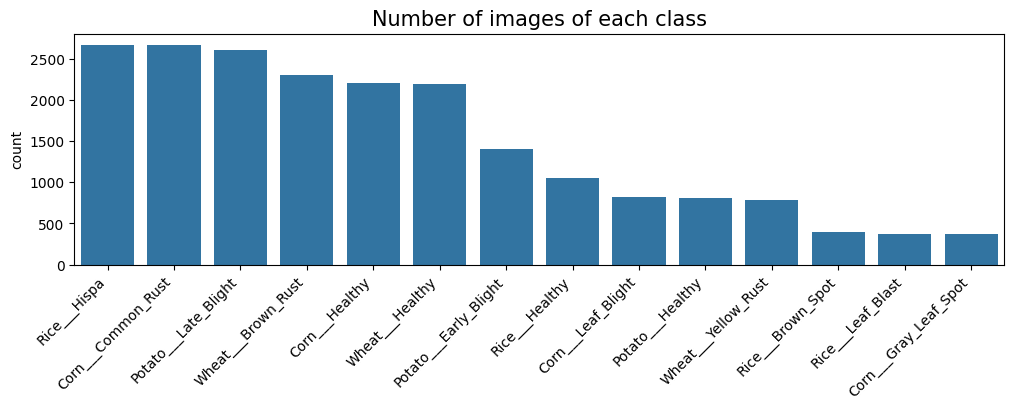

In [9]:
# visualize the class label and number of images
plt.figure(figsize=(12,3))
sns.barplot(  x = class_label, y = label_count)
plt.title("Number of images of each class", fontsize = 15)
plt.xticks(rotation=45, ha='right')
plt.show()

Rice___Hispa


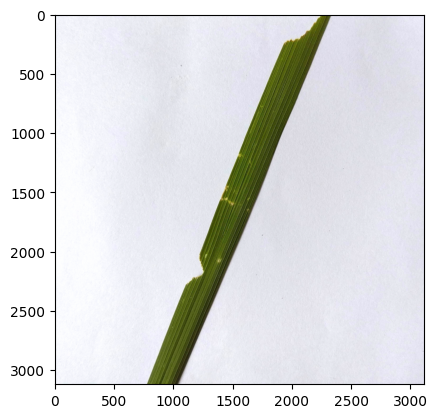

Corn___Common_Rust


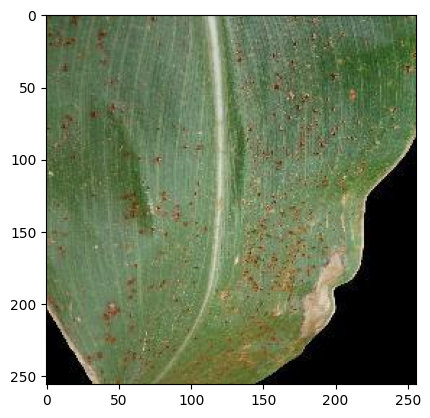

Potato___Late_Blight


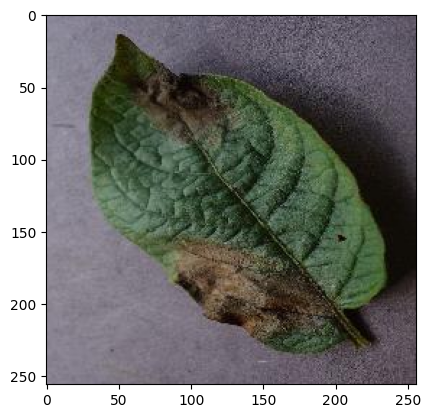

Wheat___Brown_Rust


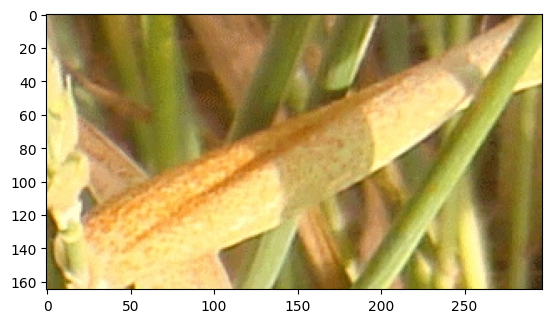

Corn___Healthy


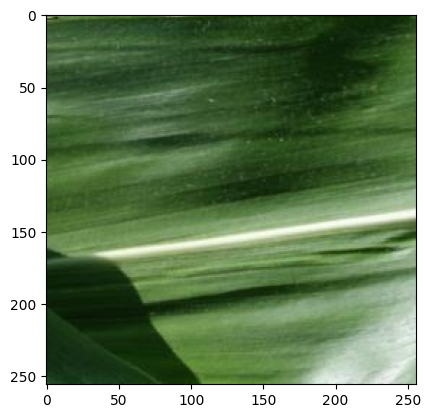

Wheat___Healthy


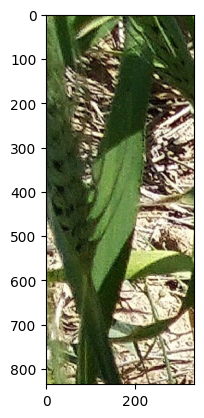

Potato___Early_Blight


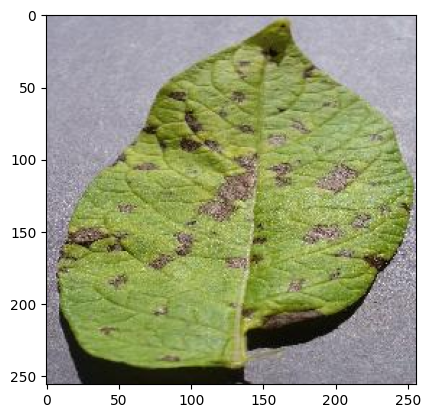

Rice___Healthy


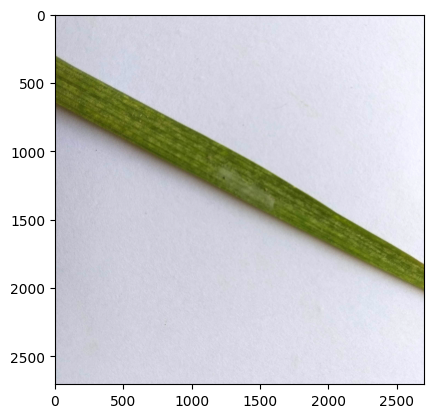

Corn___Leaf_Blight


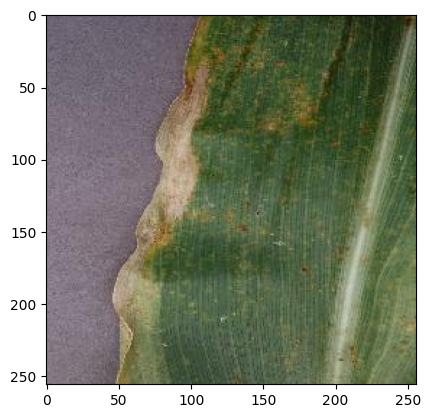

Potato___Healthy


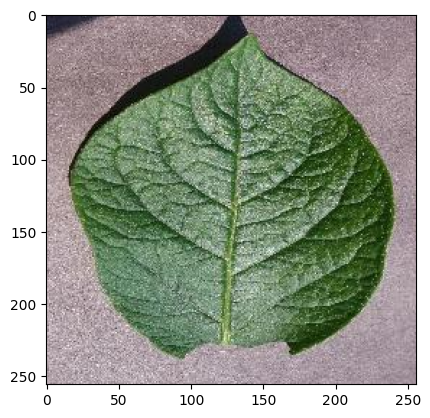

Wheat___Yellow_Rust


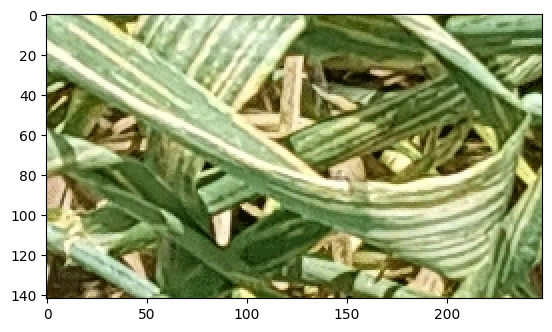

Rice___Brown_Spot


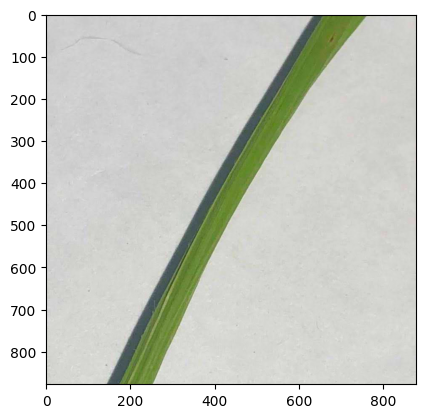

Rice___Leaf_Blast


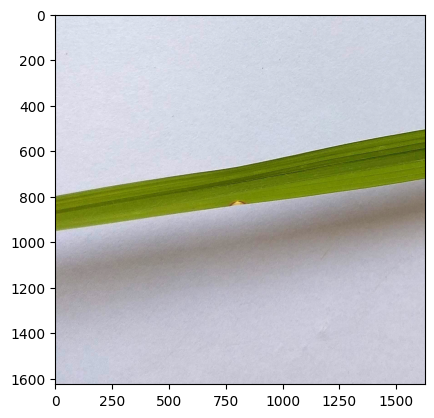

Corn___Gray_Leaf_Spot


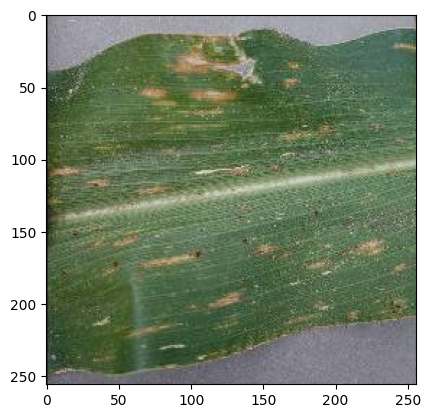

In [10]:
# covert the image to pixel
for folder in os.listdir(train_img_path):
    sub_path = train_img_path + "/" + folder

    print(folder)
    for i in range(1):
        temp_path = os.listdir(sub_path)[i]
        temp_path = sub_path + "/" + temp_path
        img = mpimg.imread(temp_path)
        imgplot = plt.imshow(img)
        plt.show()

# Data Preprocessing





In [11]:
# re-size all the images to this
IMAGE_SIZE = 224
BATCH_SIZE = 32

In [12]:
# Data augmentation for training data

train_img_datagenerator = ImageDataGenerator(rescale = 1./255,
                                  rotation_range=30,
                                  zoom_range=0.2,
                                  shear_range=0.2,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  horizontal_flip=True,
                                  vertical_flip=True,
                                  fill_mode='nearest')

test_img_datagenerator = ImageDataGenerator(rescale = 1./255)

training_set = train_img_datagenerator.flow_from_directory(train_img_path,
                                                 target_size = (IMAGE_SIZE, IMAGE_SIZE),
                                                 batch_size = BATCH_SIZE,
                                                 class_mode = 'categorical')

test_set = test_img_datagenerator.flow_from_directory(test_img_path,
                                            target_size = (IMAGE_SIZE, IMAGE_SIZE),
                                            batch_size = BATCH_SIZE,
                                            class_mode = 'categorical')

valid_set = test_img_datagenerator.flow_from_directory(
        val_img_path,
        target_size = (IMAGE_SIZE, IMAGE_SIZE),
        batch_size = BATCH_SIZE,
        class_mode = 'categorical')

Found 20637 images belonging to 14 classes.
Found 2962 images belonging to 14 classes.
Found 5891 images belonging to 14 classes.


In [13]:
training_set.class_indices

{'Corn___Common_Rust': 0,
 'Corn___Gray_Leaf_Spot': 1,
 'Corn___Healthy': 2,
 'Corn___Leaf_Blight': 3,
 'Potato___Early_Blight': 4,
 'Potato___Healthy': 5,
 'Potato___Late_Blight': 6,
 'Rice___Brown_Spot': 7,
 'Rice___Healthy': 8,
 'Rice___Hispa': 9,
 'Rice___Leaf_Blast': 10,
 'Wheat___Brown_Rust': 11,
 'Wheat___Healthy': 12,
 'Wheat___Yellow_Rust': 13}

In [14]:
# class_indices have the numeric tag for each images
train_classes = training_set.class_indices

# Storing the face and the numeric tag for future reference
result_map = {}
for crop_img_value, crop_img_name in zip(train_classes.values(), train_classes.keys()):
    result_map[crop_img_value] = crop_img_name

# Display the class names
print(result_map)

{0: 'Corn___Common_Rust', 1: 'Corn___Gray_Leaf_Spot', 2: 'Corn___Healthy', 3: 'Corn___Leaf_Blight', 4: 'Potato___Early_Blight', 5: 'Potato___Healthy', 6: 'Potato___Late_Blight', 7: 'Rice___Brown_Spot', 8: 'Rice___Healthy', 9: 'Rice___Hispa', 10: 'Rice___Leaf_Blast', 11: 'Wheat___Brown_Rust', 12: 'Wheat___Healthy', 13: 'Wheat___Yellow_Rust'}


In [15]:
NUM_CLASSES = len(result_map)
print('\n The number of output neurons or classes: ', NUM_CLASSES)


 The number of output neurons or classes:  14


## Build the Model

In [16]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [17]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)

In [18]:
DenseNet121_base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)


29084464/29084464 [==============================] - 0s 0us/step


In [19]:
for lay in DenseNet121_base_model.layers:
    lay.trainable = False

# Add layers
x = GlobalAveragePooling2D()(DenseNet121_base_model.output)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

# Create the model
model_DenseNet121 = Model(inputs=DenseNet121_base_model.input, outputs=predictions)

# Compile the model
model_DenseNet121.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])



In [20]:
model_DenseNet121.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 230, 230, 3)          0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1/conv[0][0]']      

In [21]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=6, min_lr=1e-7)
early_stop = EarlyStopping(monitor = 'val_loss', mode='min', verbose = 1, patience = 5)


In [22]:
# Train the model
model_history = model_DenseNet121.fit(
    training_set,
    steps_per_epoch=len(training_set),
    epochs=20,
    validation_data=valid_set,
    validation_steps=len(valid_set)

)

Epoch 1/20
645/645 [==============================] - 532s 802ms/step - loss: 0.6211 - accuracy: 0.8092 - val_loss: 0.2935 - val_accuracy: 0.8912
Epoch 2/20
645/645 [==============================] - 481s 745ms/step - loss: 0.2328 - accuracy: 0.9164 - val_loss: 0.2084 - val_accuracy: 0.9234
Epoch 3/20
645/645 [==============================] - 465s 720ms/step - loss: 0.1947 - accuracy: 0.9278 - val_loss: 0.1809 - val_accuracy: 0.9280
Epoch 4/20
645/645 [==============================] - 456s 707ms/step - loss: 0.1753 - accuracy: 0.9335 - val_loss: 0.1650 - val_accuracy: 0.9372
Epoch 5/20
645/645 [==============================] - 442s 685ms/step - loss: 0.1651 - accuracy: 0.9364 - val_loss: 0.1512 - val_accuracy: 0.9402
Epoch 6/20
645/645 [==============================] - 476s 738ms/step - loss: 0.1537 - accuracy: 0.9401 - val_loss: 0.1456 - val_accuracy: 0.9423
Epoch 7/20
645/645 [==============================] - 438s 679ms/step - loss: 0.1458 - accuracy: 0.9429 - val_loss: 0.1391 -

### Training Accuracy vs Validation Graph

In [23]:
accuracy = model_history.history['accuracy']
val_accuracy  = model_history.history['val_accuracy']
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

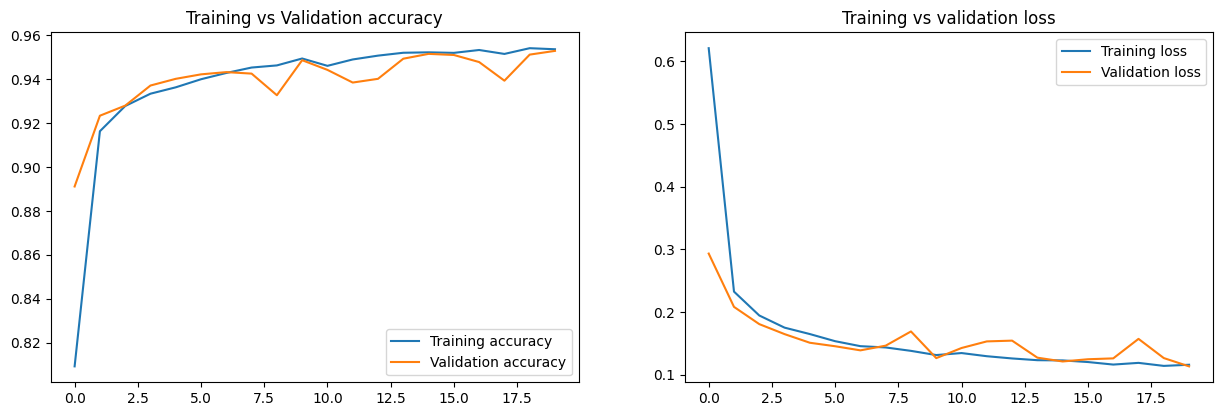

In [24]:
plt.figure(figsize=(15,10))
plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs Validation accuracy")

plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.show()

### Evaluate the Model

In [25]:
test_loss, test_acc = model_DenseNet121.evaluate(test_set, steps=len(test_set))
print('\nTest accuracy:', test_acc)

93/93 [==============================] - 36s 388ms/step - loss: 0.1160 - accuracy: 0.9490

Test accuracy: 0.9490209221839905


In [26]:
model_DenseNet121.save(r"/content/drive/MyDrive/Upwork/model_DenseNet121.h5")
## Saving the model


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Confusion Matrix


93/93 [==============================] - 30s 302ms/step


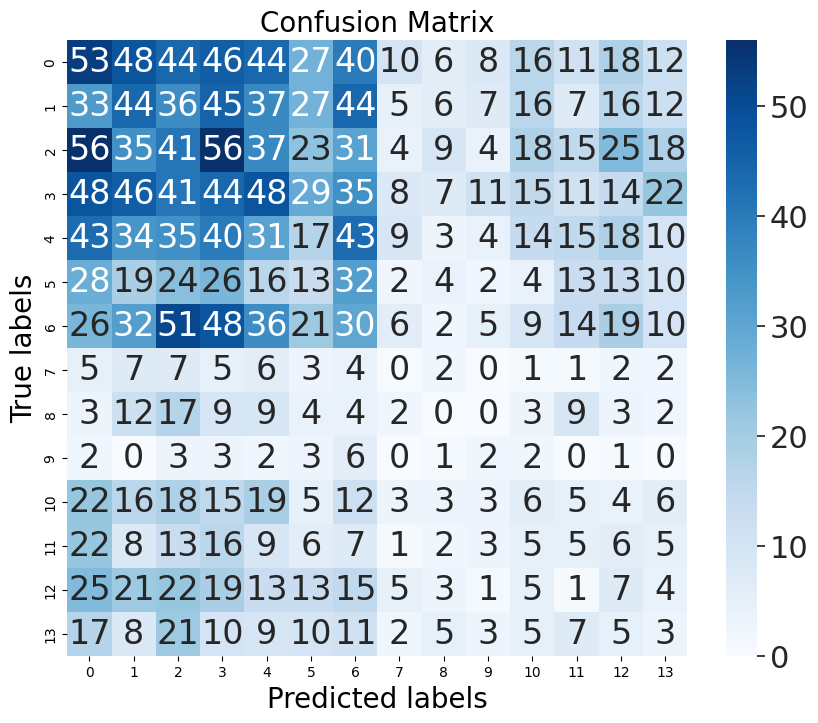

In [27]:
pred_y = model_DenseNet121.predict(test_set)
y_pred = np.argmax(pred_y, axis=1)

y_test = test_set.classes

cm = confusion_matrix(y_pred, y_test)

plt.figure(figsize=(10, 8))
ax = plt.subplot()
sns.set(font_scale=2.0)
sns.heatmap(cm, annot=True, fmt='g', cmap="Blues", ax=ax);

# labels, title and ticks
ax.set_xlabel('Predicted labels', fontsize=20);ax.set_ylabel('True labels', fontsize=20);
ax.set_title('Confusion Matrix', fontsize=20);


### Make Prediction On Different Test Image

In [28]:
# Load the test image
test_img_path = r"/content/Crop_Disease/test/Wheat___Brown_Rust/Brown_rust052.jpg"


In [29]:
# Preprocess the test image
test_img = tf.keras.preprocessing.image.load_img(test_img_path, target_size=(224, 224))
test_img_array = tf.keras.preprocessing.image.img_to_array(test_img)
test_img_array = np.expand_dims(test_img_array, axis=0)
test_img_array = test_img_array / 255.0

In [30]:
# Make predictions
pred = model_DenseNet121.predict(test_img_array, verbose=0)
pred_index = np.argmax(pred)
predict_class_label = result_map[pred_index]

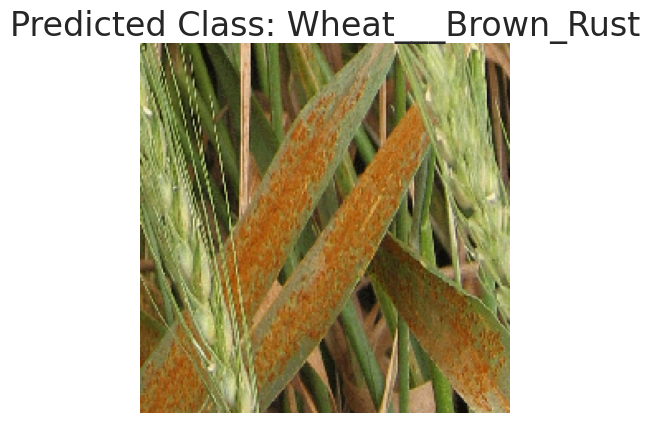

In [31]:
# Display the test image and predicted class label
plt.imshow(test_img)
plt.title(f"Predicted Class: {predict_class_label}")
plt.axis('off')
plt.show()

# Test with DenseNet121 save model

> Add blockquote



In [32]:
# Load the model
model = tf.keras.models.load_model(r'/content/drive/MyDrive/Upwork/model_DenseNet121.h5')

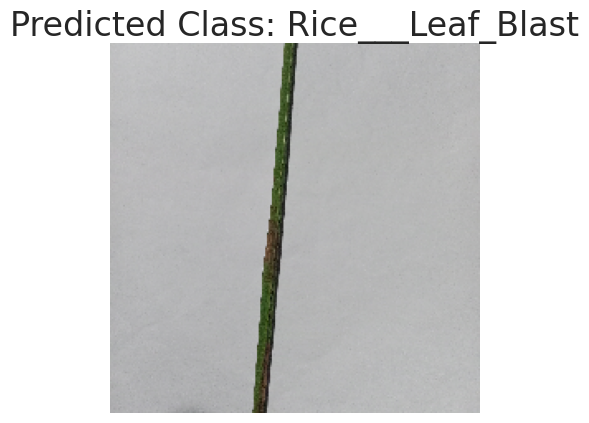

In [33]:
# Load the model
test_img_path = r"/content/Crop_Disease/test/Rice___Leaf_Blast/IMG20201109190308_00.jpg"

# Preprocess the test image
test_img = tf.keras.preprocessing.image.load_img(test_img_path, target_size=(224, 224))
test_img_array = tf.keras.preprocessing.image.img_to_array(test_img)
test_img_array = np.expand_dims(test_img_array, axis=0)
test_img_array = test_img_array / 255.0

# Make predictions
pred = model_DenseNet121.predict(test_img_array, verbose=0)
pred_index = np.argmax(pred)
predict_class_label = result_map[pred_index]

# Display the test image and predicted class label
plt.imshow(test_img)
plt.title(f"Predicted Class: {predict_class_label}")
plt.axis('off')
plt.show()